# Fed Data Collection and Processing
---
This notebook orchestrates the scraping and processing scripts to collect data from the Federal Reserve website.


## 1. Environment Setup
- Check working directory.
- Verify that necessary directories (like `../data`) exist.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv

# 设置绘图风格
sns.set(style='whitegrid', font_scale=1.2)

# 让 pandas 显示更多列
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 50)

print("Environment setup complete.")

Environment setup complete.


## 2. Meeting Minutes
- Scrape raw HTML/PDF from the FOMC website.
- Process the text into structured sentence-level CSV files.

In [2]:
DATA_DIR = '../data'

FILES = {
    'minutes': 'fed_minutes_sentences_structured.csv',
    'press': 'fed_press_conf_structured.csv',
    'speech': 'fed_speeches_sentences.csv' 
}

print(f"Data Directory set to: {os.path.abspath(DATA_DIR)}")

Data Directory set to: e:\Textming\data



## 3. Speeches
- Collect transcripts of speeches from Fed officials.
- Clean and format the data.

In [6]:
def load_and_standardize(file_name, source_type):
    """
    读取 CSV，统一列名，并添加来源标签
    """
    path = os.path.join(DATA_DIR, file_name)
    if not os.path.exists(path):
        print(f"[Warning] File not found: {path}. Skipping...")
        return pd.DataFrame()
    
    try:
        df = pd.read_csv(path)
    except Exception as e:
        print(f"[Error] Failed to read {file_name}: {e}")
        return pd.DataFrame()
    
    # 统一列名映射
    if 'sentence_text' in df.columns:
        df = df.rename(columns={'sentence_text': 'text'})
    elif 'section_text' in df.columns:
        df = df.rename(columns={'section_text': 'text'})
    
    if 'section' not in df.columns:
        df['section'] = 'General'
        
    df['source'] = source_type
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    
    if df['date'].isnull().any():
        df = df.dropna(subset=['date'])

    # 确保列一致性
    if 'speaker' not in df.columns:
        df['speaker'] = 'N/A'
        
    cols = ['date', 'text', 'section', 'source', 'speaker']
    return df[cols]

## 4. Merging Datasets
- Combine all sources into a single `df_master` dataframe.


In [7]:
print("--- Loading Datasets ---")

df_minutes = load_and_standardize(FILES['minutes'], 'Minutes')
df_press = load_and_standardize(FILES['press'], 'Press Conf')
df_speech = load_and_standardize(FILES['speech'], 'Speech')

frames = [df for df in [df_minutes, df_press, df_speech] if not df.empty]

if frames:
    df_master = pd.concat(frames, ignore_index=True)
    df_master = df_master.sort_values('date').reset_index(drop=True)
    print(f"Total Raw Corpus Size: {len(df_master)} sentences")
    display(df_master.head(3))
else:
    print("[Error] No data loaded.")

--- Loading Datasets ---
Total Raw Corpus Size: 7518 sentences


,date,text,section,source,speaker
0,2018-01-31,Developments in Financial Markets and Open Mar...,Developments in Financial Markets,Minutes,N/A
1,2018-01-31,Staff Review of the Financial SituationDomesti...,Staff Review of Financial Situation,Minutes,N/A
2,2018-01-31,A strengthening outlook for economic growth in...,Staff Review of Financial Situation,Minutes,N/A


## 5. Quality Control & Filtering
- Remove empty rows.
- Filter out "noise" (e.g., sentences shorter than 5 words that lack semantic value).


In [8]:
if 'df_master' in locals() and not df_master.empty:
    # A. 去除文本为空的行
    df_master = df_master.dropna(subset=['text'])

    # B. 噪声过滤：去除少于 5 个词的句子
    df_master['word_count'] = df_master['text'].apply(lambda x: len(str(x).split()))
    df_clean = df_master[df_master['word_count'] >= 5].copy()
    
    print(f"1. Dropped {len(df_master) - len(df_clean)} short/noisy sentences.")
    print(f"2. Date Range: {df_clean['date'].min().date()} to {df_clean['date'].max().date()}")
    print(f"Final Cleaned Corpus Size: {len(df_clean)} sentences")
else:
    print("No data to clean.")

1. Dropped 26 short/noisy sentences.
2. Date Range: 2018-01-31 to 2024-12-18
Final Cleaned Corpus Size: 7492 sentences


## 6. Exploratory Data Analysis (EDA)
- Visualize the distribution of data across sources.
- Analyze sentence length distribution.

C:\Users\Administrator\AppData\Local\Temp\ipykernel_34040\2746898593.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, x='source', palette='viridis')


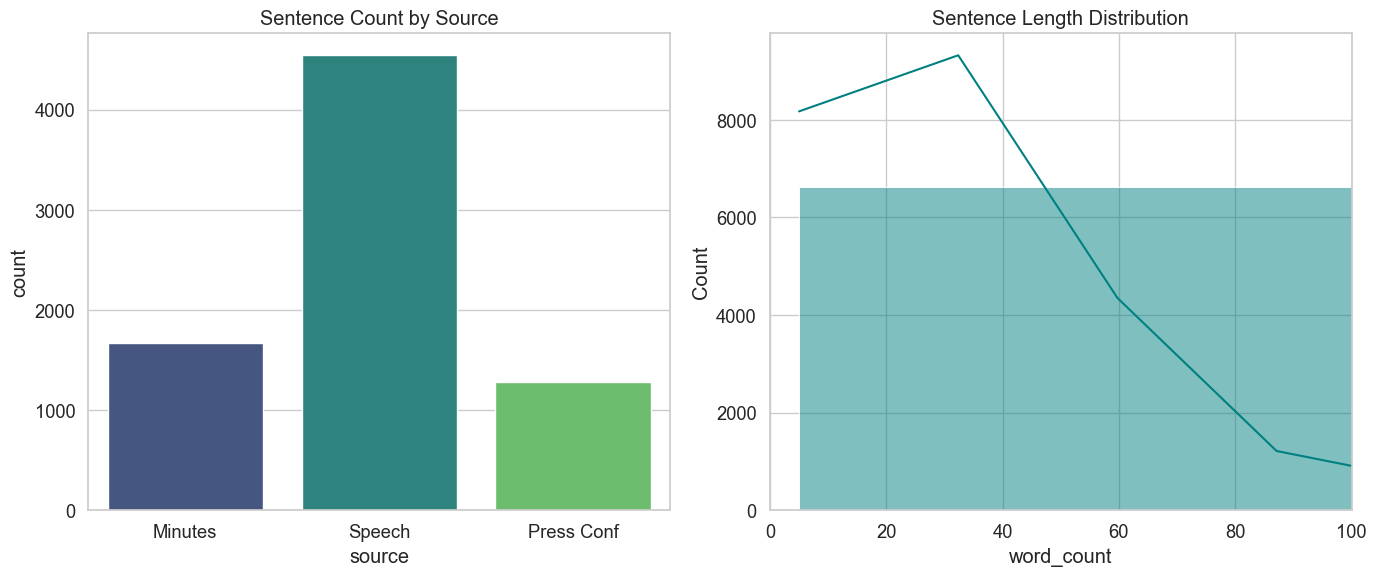

In [10]:
if 'df_clean' in locals() and not df_clean.empty:
    plt.figure(figsize=(14, 6))

    # 图1: 各类来源的数据量对比
    plt.subplot(1, 2, 1)
    sns.countplot(data=df_clean, x='source', palette='viridis')
    plt.title('Sentence Count by Source')

    # 图2: 句子长度分布
    plt.subplot(1, 2, 2)
    sns.histplot(df_clean['word_count'], bins=50, kde=True, color='teal')
    plt.title('Sentence Length Distribution')
    plt.xlim(0, 100)

    plt.tight_layout()
    plt.show()

## 7. Exporting the Master Corpus
- Save the final cleaned dataset to `fed_master_corpus.csv` for downstream NLP tasks.

In [11]:
if 'df_clean' in locals() and not df_clean.empty:
    output_path = os.path.join(DATA_DIR, 'fed_master_corpus.csv')
    
    # 使用 utf-8-sig 编码以防 Excel 打开乱码
    df_clean.to_csv(output_path, index=False, encoding='utf-8-sig', quoting=csv.QUOTE_ALL)

    print(f"[Success] Master Corpus saved to: {os.path.abspath(output_path)}")
    print(f"Final Shape: {df_clean.shape}")
else:
    print("Skipping save because dataframe is empty.")

[Success] Master Corpus saved to: e:\Textming\data\fed_master_corpus.csv
Final Shape: (7492, 6)
